In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

from sklearn.model_selection import GroupKFold

# local modules
import sys
sys.path.append("../src")
from preproc import preprocess_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Call the function
df_train, df_test, numerical_cols, categorical_cols = preprocess_data(
    df_train,
    df_test,
    scale_utility=True
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

Numerical Columns: 588
Categorical Columns: 10


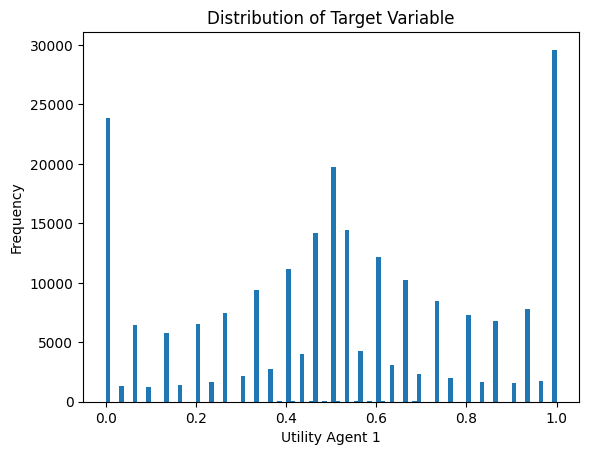

In [4]:
plt.hist(df_train['utility_agent1_scaled'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model


In [5]:
# Define the number of folds for cross-validation
num_folds = 5

# Define the column for stratified or group k-fold
groups_col = 'GameRulesetName'
gkf = GroupKFold(n_splits=num_folds)
split_list = gkf.split(df_train, groups=df_train[groups_col])

target = 'utility_agent1'
#target = 'utility_agent1_scaled'

# Define the parameters
params = {
    'objective': "reg:squarederror" if target == 'utility_agent1' else "binary:logistic",
    'eval_metric': 'rmse',
    'max_depth': 5,
    'learning_rate': 0.05,
}

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
    y_train, y_val = X_train[target], X_val[target]

    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]
    
    # Convert to DMatrix format
    train_data = xgb.DMatrix(
        data=X_train[numerical_cols + categorical_cols],
        label=y_train,
        feature_types=feature_types,
        enable_categorical=True,
    )
    val_data = xgb.DMatrix(
        data=X_val[numerical_cols + categorical_cols],
        label=y_val,
        feature_types=feature_types,
        enable_categorical=True,
    )

    # Train the model
    model = xgb.train(
        params,
        train_data,
        num_boost_round=2000,
        evals=[(val_data, 'val')],
        verbose_eval=25,
    )
    
    # Save the trained model to the list
    trained_models.append(model)

    # predict on validation set
    y_pred = model.predict(val_data)
    
    if target == "utility_agent1_scaled":
        # scale back predictions and true values to -1 to 1 range
        y_pred = y_pred * 2 - 1
        y_val = y_val * 2 - 1
    else:
        y_pred = np.clip(y_pred, -1, 1)
    
    # Compute RMSE on scaled values
    rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_val
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))



Fold 1
[0]	val-rmse:0.61226
[25]	val-rmse:0.52545
[50]	val-rmse:0.50341
[75]	val-rmse:0.49605
[100]	val-rmse:0.49180
[125]	val-rmse:0.48934
[150]	val-rmse:0.48699
[175]	val-rmse:0.48272
[200]	val-rmse:0.48097
[225]	val-rmse:0.47892
[250]	val-rmse:0.47647
[275]	val-rmse:0.47558
[300]	val-rmse:0.47265
[325]	val-rmse:0.47093
[350]	val-rmse:0.46943
[375]	val-rmse:0.46805
[400]	val-rmse:0.46672
[425]	val-rmse:0.46585
[450]	val-rmse:0.46424
[475]	val-rmse:0.46312
[500]	val-rmse:0.46237
[525]	val-rmse:0.46162
[550]	val-rmse:0.46133
[575]	val-rmse:0.46089
[600]	val-rmse:0.46061
[625]	val-rmse:0.45985
[650]	val-rmse:0.45987
[675]	val-rmse:0.45954
[700]	val-rmse:0.45963
[725]	val-rmse:0.45922
[750]	val-rmse:0.45888
[775]	val-rmse:0.45822
[800]	val-rmse:0.45823
[825]	val-rmse:0.45817
[850]	val-rmse:0.45774
[875]	val-rmse:0.45728
[900]	val-rmse:0.45684
[925]	val-rmse:0.45628
[950]	val-rmse:0.45626
[975]	val-rmse:0.45615
[1000]	val-rmse:0.45592
[1025]	val-rmse:0.45570
[1050]	val-rmse:0.45557
[1075]

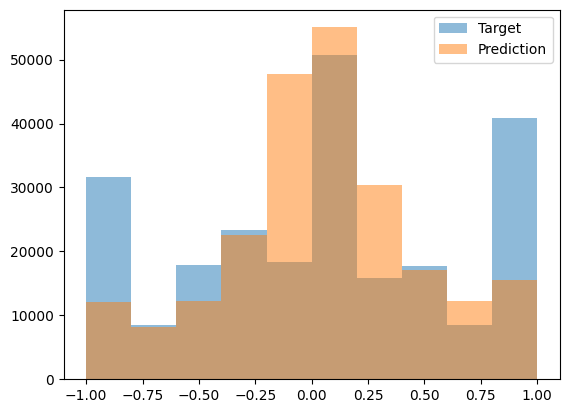

In [6]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

In [7]:
# Predict on the test set using all trained models
# test_predictions = [
#     model.predict(df_test[numerical_cols + categorical_cols]) 
#     for model in trained_models
# ]

# Average predictions from all models
# final_predictions = np.mean(test_predictions[0], axis=0)

# # Create a DataFrame with the predictions
# results_df = pd.DataFrame({
#     'Id': df_test['Id'],
#     'utility_agent1': final_predictions
# })

# Save the results to a CSV file
# results_df.to_csv('lightgbm_predictions.csv', index=False)
# print("Predictions saved to 'lightgbm_predictions.csv'")

***